# Decion trees and random forests

## Data

Use the [World Value Survey](http://www.worldvaluessurvey.org/WVSDocumentationWV6.jsp) datafiles and corresponding questionaire and codebook files to understand what is in the data.

## Overarching research question

Explain what variables effect happiness (`V10`) using decison-tree learning.

## Method

There are many tools used for this, we apply [SciKit learn](https://scikit-learn.org/stable/modules/tree.html).

In [34]:
## create new data matrix for decision tree analysis

import csv

dependent = 'V10'
independent = [ 'V4', 'V5', 'V6', 'V7', 'V8', 'V9']

dependent_data = []
independent_data = []

for line in csv.DictReader( open('data/wvs.csv') ):
    
    dependent_data.append( line[ dependent ] )
    
    dd = []
    for variable in independent:
        dd.append( line[variable] )
    independent_data.append( dd )
    
print( len( dependent_data ) )
print( len( independent_data ) )

89565
89565


In [35]:
from sklearn import tree

decision_tree = tree.DecisionTreeClassifier( max_depth = 3) # tree.DecisionTreeRegressor() # for regression model
model = decision_tree.fit( independent_data, dependent_data )

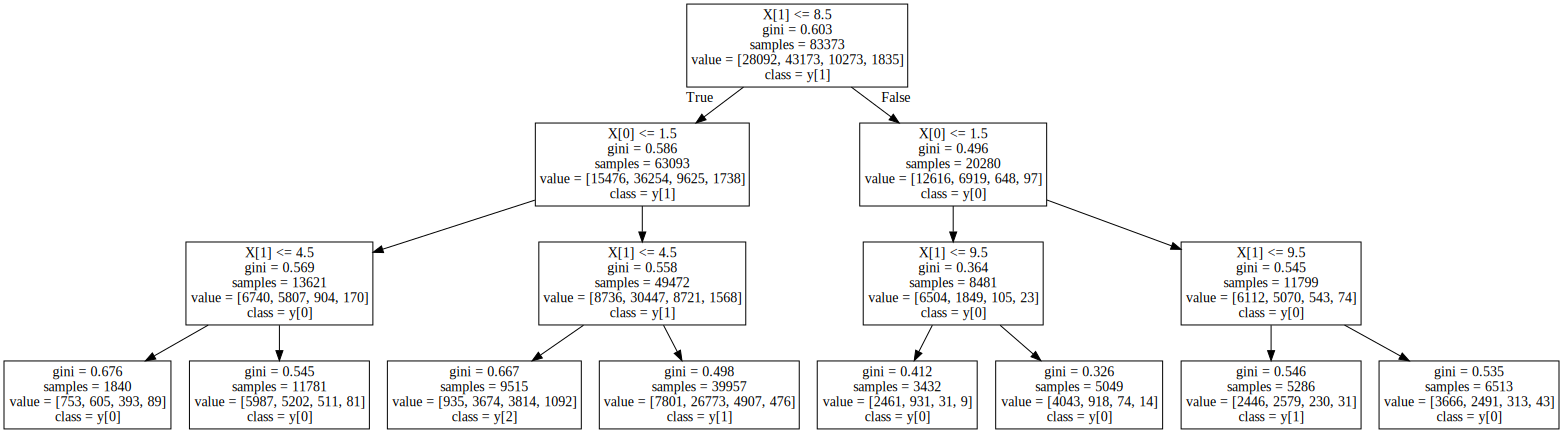

In [31]:
import graphviz
from IPython.display import display
image = tree.export_graphviz( model, class_names = True )
display( graphviz.Source( image ) ) ## or you could write the graphviz format to a file and visualise it using some other format

## Model analysis

As we spoke, there are [many different approaches to evaluate the quality of a model](https://scikit-learn.org/stable/modules/model_evaluation.html#model-evaluation). Beyond single metrics (like accuracy score, kappa score), confusion matrix may be beneficial to understand model performance.

In [37]:
from sklearn import metrics

predicted_values = model.predict( independent_data )
print(metrics.confusion_matrix( predicted_values, dependent_data ))

[[    0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0]
 [   39    40     0  8244  7092  1826   526]
 [  475   198     6 21012 38694  9388  2025]
 [    0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0]]


## Tasks

* Choose better or more interesting values to be modelled.

I chose the following variables based on "folk sociological" ideas and intuition of what could effect happiness: 

* V11: "State of health (subjective)" 1: Very good - 4: Poor 
* V23: "Satisfaction with your life" 1: Completely dissatisfied - 10: Completely satisfied
* V59: "Satisfaction with financial situation of household" 1: Completely dissatisfied - 10: completely satisfied
* V147: "Religious person" 1: A religious person, 2: Not a religious person, 3: An atheist

* Improve the data preprocessing (remove missing values etc.)

In [4]:
import csv

len_full_data = 89565 ## n of rows in the original data

dependent = 'V10'
independent = [ 'V11', 'V23', 'V59', 'V147' ]

dependent_data = []
independent_data = []

for line in csv.DictReader( open('data/wvs.csv') ):
    
    dd = []
    
    skip_line = False
    
    if int( line[dependent] ) <= 0:
        skip_line = True

    for variable in independent:
        if int( line[variable] ) <= 0:
            skip_line = True
            break
    
    if skip_line == False:
        dependent_data.append( line[dependent] )
        for variable in independent:
            dd.append( line[variable] )
        independent_data.append(dd)

assert len( dependent_data ) == len( independent_data)

print('Number of removed rows: ', 89565 - len(dependent_data), 'of 98565')

Number of removed rows:  6192 of 98565


In [8]:
from sklearn import tree
from sklearn import metrics

first_decision_tree = tree.DecisionTreeClassifier( max_depth = 3)
model = first_decision_tree.fit( independent_data, dependent_data )

predicted_values = model.predict( independent_data )
print( metrics.confusion_matrix(predicted_values, dependent_data) )
print( '\n', metrics.accuracy_score(predicted_values, dependent_data) )


[[16910 10147  1322   236]
 [10247 29352  5137   507]
 [  935  3674  3814  1092]
 [    0     0     0     0]]

 0.6006261019754597


From the confusion matrix we can see that the model is really really bad at classifying cases where people report their happiness as "not happy at all". In addition, its accuracy score is only about 60%. 

* Apply training data - test data split in the data analysis stage. Does that improve the analysis at all?

In [14]:
from sklearn.model_selection import train_test_split

dependent_train, dependent_test, independent_train, independent_test = train_test_split(dependent_data, independent_data, 
                                                                                      test_size=0.20)

second: decision_tree = tree.DecisionTreeClassifier( max_depth = 3) # tree.DecisionTreeRegressor() # for regression model
model = decision_tree.fit( independent_train, dependent_train )

predicted_values = model.predict( independent_test )
print(metrics.confusion_matrix( predicted_values, dependent_test))
print('\n', metrics.accuracy_score(predicted_values, dependent_test))

[[3355 2054  272   39]
 [2082 5904 1036   93]
 [ 194  708  718  220]
 [   0    0    0    0]]

 0.5983208395802099


Data - test split did not improve the analysis. It does not classify any cases of "not happy at all" and the accuracy is still about 60%. 

* Increase the maximum depth of the decision tree. Does it improve the analysis at all?

In [16]:
for i in range (3, 15): 
    decision_tree = tree.DecisionTreeClassifier( max_depth = i) 
    model = decision_tree.fit( independent_train, dependent_train )
    predicted_values = model.predict( independent_test )
    print(i, '{:0.3f}'.format(metrics.accuracy_score( predicted_values, dependent_test )))

3 0.598
4 0.614
5 0.614
6 0.615
7 0.616
8 0.613
9 0.612
10 0.613
11 0.613
12 0.613
13 0.613
14 0.613


The accuracy score improves until the depth of the tree is 7 and after that it starts getting worse and stabilizes at 0.613. Taking accuracy score as a premilinary evaluation metric it seems that we should look decision trees with the depth of 4, 7 and 10 more closely. 

In [22]:
tree_depth = [4, 7, 10]

for i in (tree_depth):
    decision_tree = tree.DecisionTreeClassifier( max_depth = i) 
    model = decision_tree.fit( independent_train, dependent_train )
    predicted_values = model.predict( independent_test )
    print('Depth:', i, ' \n')
    print(metrics.confusion_matrix( predicted_values, dependent_test))
    print('\n', metrics.accuracy_score(predicted_values, dependent_test), '\n')



Depth: 4  

[[3108 1706  177   30]
 [2427 6612 1331  153]
 [  96  348  518  169]
 [   0    0    0    0]]

 0.6139730134932534 

Depth: 7  

[[3196 1796  203   29]
 [2308 6421 1187  130]
 [ 121  434  593  136]
 [   6   15   43   57]]

 0.615712143928036 

Depth: 10  

[[3249 1859  204   32]
 [2295 6462 1326  152]
 [  82  338  464  120]
 [   5    7   32   48]]

 0.6130734632683659 



If we compare depth of 4, 7 and 10 we see that after the depth of 7 the tree classifies even those cases where the response is "not happy at all". In addition, it seems that the depth of 7 provides the best classification overall. 

## Random forests -  a decision tree on steroids.

The challenge with decision trees is that they run a single model on the dataset.
However, like many other machine learning algorihms (both supervised and unsupervised), it relies on a single random state.
It can overfit or does not lead to best accuracy.
[Random forests](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) fix these issues through creating more trees, examining their differences and creating a classifier through combining different decision trees.

In [26]:
from sklearn import ensemble

random_forest = ensemble.RandomForestClassifier()
model = random_forest.fit( independent_data, dependent_data )

C:\Users\mikko\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [27]:
random_forest = ensemble.RandomForestClassifier()
model = random_forest.fit( independent_train, dependent_train )

C:\Users\mikko\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [28]:
predicted_values = model.predict( independent_test )
print('\n', metrics.accuracy_score(predicted_values, dependent_test), '\n')
print(metrics.confusion_matrix( predicted_values, dependent_test ))

[[3203 1810  200   32]
 [2337 6499 1320  149]
 [  86  338  467  118]
 [   5   19   39   53]]

 0.6130134932533733 



## Some reflections

As it is quite often said, the logic behind descision trees is intuitively easily to understand. Especially because they are easy to visualize and therefore it is quite easy to understand "how they work". As I found while doing the exercise flat trees (i.e. trees with low depth) are easy to understand. With this I mean that it is easy to understand how/why they classify the cases as they do (e.g. what are the relevant variables and their values when a tree makes a decision). However, understanding a tree becomes really difficult when the depth of the tree increases. For example, when the depth of the tree in this exercise is ten, it is quite difficult to provide simple discursive description of how/why tree classifies the cases as it does. This aspect of decision trees also made me wonder what kind of social scientific knowledge they are able to produce. The task was to "explain what variables effect happiness", which made me to think about what kind of explanation I could find with decision trees for this question. 

I would say that the goals of social scientific research can roughly be divided into three distinct classes: 1) to provide interpretation of the social world/phenomena, 2) to provide explanations of the social world/phenomena and 3) to provide predictions about the social world/phenomena. It seems that decision trees are strongly associated with the third goals - to provide predictions about the social world/phenomena. For example, "if we know these things about this case, based on the previous knowledge about similar cases, what will happen to this case in the future". What I kept wondering while doing the exercise was, does a decision tree also provide some kind of explanation for why a case is classified certain way. Of course, when the tree is flat, we can provide an description of the "structure" of the decision. However, the deeper the tree becomes, the more difficult it is use it as an explanation. Hence, what I kept wondering while doing the exercise was what does the tree actually tell us about the social world. Of course, we could also ask does it have tell us something about the social world since decision trees seem to be good tools for the third task, which is, predicting and classifying unknown cases. 

In the exercise I ended up with a model where a model build on state of health, statisfaction with one's life, satisfaction with one's financial situation and being religious were able to produce a model that was able to classify about 61.5% of cases from the test data right. In some sense this kind of model could be used to provide guidelines for policies such as "if we want to increase the happiness of people" we should "make sure that people are healthy and that they are satisfied with their lives". Which I of course find as an interesting result, but I am not sure if we provided any kind of explanation for why a person (or a group of people) is(/are) happy or unhappy. Hence, what I was left wondering was what kind of knowledge about the social world decision trees produce. 